In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

resultsPath = Path("../results/MPI_7.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["numIterations"] = dataFrame["numIterations"].astype(int)
dataFrame["computeUnits"] = dataFrame["computeUnits"].astype(int)
dataFrame["avgWallSeconds"] = dataFrame["avgWallSeconds"].astype(float)
dataFrame["avgCommSeconds"] = dataFrame["avgCommSeconds"].astype(float)
dataFrame["avgComputeSeconds"] = dataFrame["avgComputeSeconds"].astype(float)
dataFrame.head(6)

print("Rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Message sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Processes:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)

Rows: 1200
Modes: ['blocking' 'nonblocking' 'compute_only' 'comm_only']
Message sizes: [1024, 16384, 65536, 262144, 1048576]
Processes: [1, 2, 4, 6, 8]


,testType,messageSizeBytes,numProcesses,mode,numIterations,computeUnits,avgWallSeconds,avgCommSeconds,avgComputeSeconds,runIndex,mpiEnv
0,MPI_7,1024,1,blocking,50,0,0.000010,0.000002,0.000002,1,SLURM_NTASKS=1;JOBID=18210
1,MPI_7,1024,1,nonblocking,50,0,0.000007,0.000000,0.000003,1,SLURM_NTASKS=1;JOBID=18213
2,MPI_7,1024,1,blocking,50,0,0.000011,0.000003,0.000003,2,SLURM_NTASKS=1;JOBID=18211
3,MPI_7,1024,1,blocking,50,0,0.000012,0.000003,0.000003,3,SLURM_NTASKS=1;JOBID=18212
4,MPI_7,1024,1,nonblocking,50,0,0.000008,0.000000,0.000003,2,SLURM_NTASKS=1;JOBID=18214
5,MPI_7,1024,1,compute_only,50,0,0.000006,0.000000,0.000002,3,SLURM_NTASKS=1;JOBID=18221
6,MPI_7,1024,1,compute_only,50,0,0.000007,0.000000,0.000003,2,SLURM_NTASKS=1;JOBID=18220
7,MPI_7,1024,1,compute_only,50,0,0.000005,0.000000,0.000002,1,SLURM_NTASKS=1;JOBID=18219


In [3]:
grouped = dataFrame.groupby(["mode","messageSizeBytes","numProcesses","computeUnits"], as_index=False).agg(
    medianWall=("avgWallSeconds","median"),
    medianComm=("avgCommSeconds","median"),
    medianCompute=("avgComputeSeconds","median"),
    count=("avgWallSeconds","count"),
    stdWall=("avgWallSeconds","std")
)
grouped["stdWall"] = grouped["stdWall"].fillna(0.0)
grouped.head(12)


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall
0,blocking,1024,1,0,0.000011,0.000003,0.000003,3,1.000000e-06
1,blocking,1024,1,10,0.027239,0.000002,0.027231,3,1.696857e-03
2,blocking,1024,1,50,0.123961,0.000002,0.123953,3,1.470891e-03
3,blocking,1024,1,200,0.514523,0.000002,0.514514,3,8.132723e-03
4,blocking,1024,2,0,0.000165,0.000157,0.000002,3,3.407345e-05
5,blocking,1024,2,10,0.024877,0.000336,0.024536,3,6.694416e-03
6,blocking,1024,2,50,0.124107,0.001163,0.122901,3,6.653811e-04
7,blocking,1024,2,200,0.516491,0.001816,0.514667,3,2.075438e-03
8,blocking,1024,4,0,0.000229,0.000220,0.000002,3,1.767229e-04
9,blocking,1024,4,10,0.038412,0.006675,0.031667,3,5.414244e-03


In [4]:
computeOnly = grouped[(grouped["mode"]=="compute_only") & (grouped["computeUnits"]>0)]

computeOnly = computeOnly.copy()
computeOnly["perUnitCompute"] = computeOnly["medianCompute"] / computeOnly["computeUnits"]

globalPerUnit = computeOnly["perUnitCompute"].median() if not computeOnly.empty else np.nan
print("Global per-unit compute time (median from compute_only):", globalPerUnit)
computeOnly.head()


Global per-unit compute time (median from compute_only): 0.0026730300000000003


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall,perUnitCompute
201,compute_only,1024,1,10,0.028480,0.0,0.028475,3,0.003636,0.002848
202,compute_only,1024,1,50,0.126155,0.0,0.126151,3,0.001593,0.002523
203,compute_only,1024,1,200,0.515288,0.0,0.515283,3,0.006186,0.002576
205,compute_only,1024,2,10,0.024601,0.0,0.024597,3,0.000892,0.002460
206,compute_only,1024,2,50,0.133082,0.0,0.133078,3,0.008313,0.002662


In [5]:
nb = grouped[grouped["mode"] == "nonblocking"].copy()

def getPerUnit(row):
    same = computeOnly[
        (computeOnly["messageSizeBytes"] == row["messageSizeBytes"]) &
        (computeOnly["numProcesses"] == row["numProcesses"])
    ]
    if not same.empty:
        return same["perUnitCompute"].median()
    return globalPerUnit

nb["perUnitCompute"] = nb.apply(getPerUnit, axis=1)
unitsSeries = pd.Series([pd.NA] * len(nb), index=nb.index, dtype="Int64")

maskValid = nb["perUnitCompute"] > 0
if maskValid.any():
    computedValues = np.ceil(nb.loc[maskValid, "medianComm"] / nb.loc[maskValid, "perUnitCompute"]).astype("int64")
    unitsSeries.loc[maskValid] = computedValues.values
nb["unitsNeeded"] = unitsSeries
nb[["messageSizeBytes","numProcesses","computeUnits","medianComm","perUnitCompute","unitsNeeded"]].head(12)


,messageSizeBytes,numProcesses,computeUnits,medianComm,perUnitCompute,unitsNeeded
300,1024,1,0,0.000000,0.002576,0
301,1024,1,10,0.000000,0.002576,0
302,1024,1,50,0.000000,0.002576,0
303,1024,1,200,0.000000,0.002576,0
304,1024,2,0,0.000052,0.002554,1
305,1024,2,10,0.000060,0.002554,1
306,1024,2,50,0.000159,0.002554,1
307,1024,2,200,0.000078,0.002554,1
308,1024,4,0,0.000105,0.002685,1
309,1024,4,10,0.007069,0.002685,3


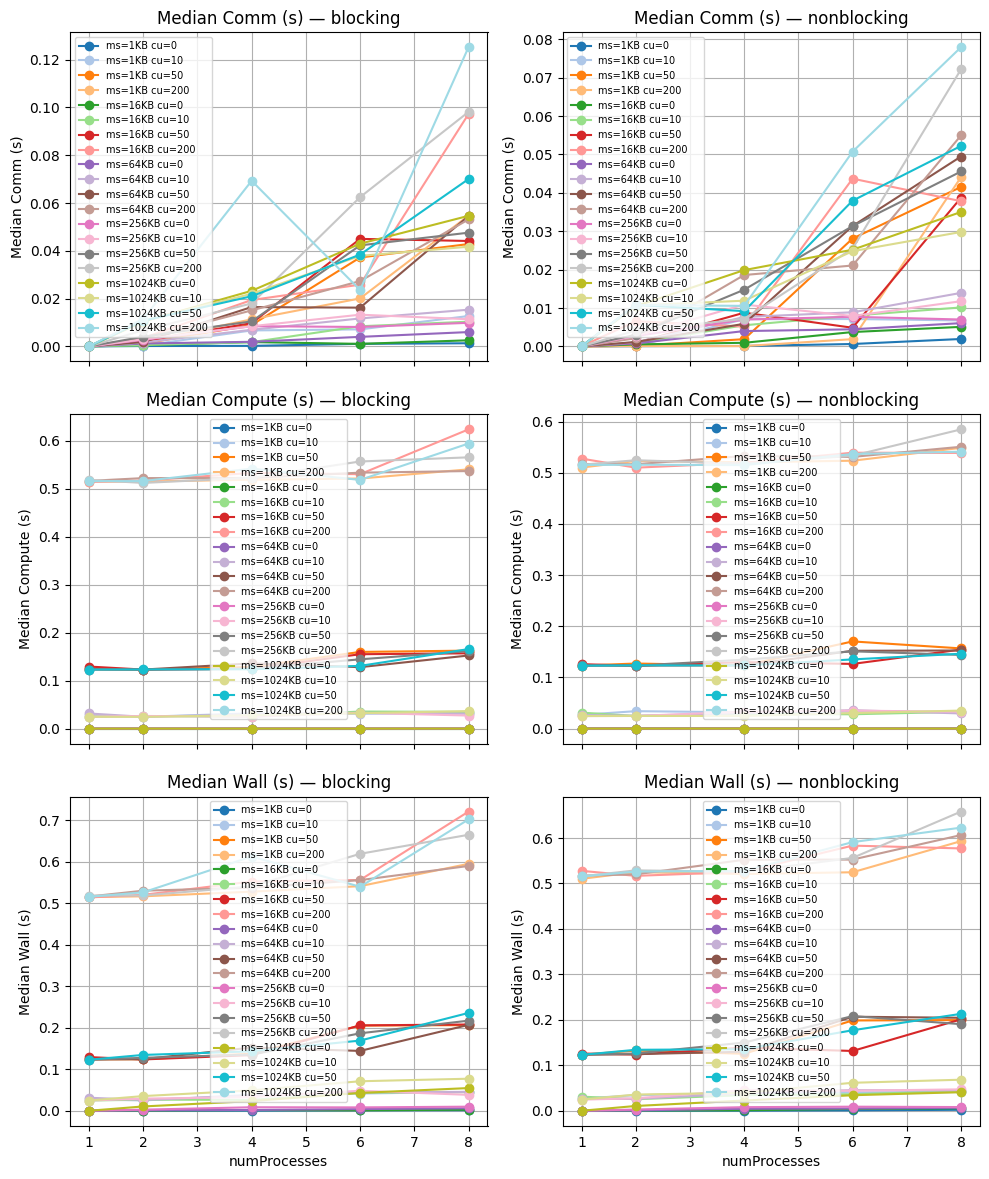

In [11]:
modes = ["blocking","nonblocking"]
metrics = ["medianComm","medianCompute","medianWall"]
metricLabels = {"medianComm":"Median Comm (s)", "medianCompute":"Median Compute (s)", "medianWall":"Median Wall (s)"}

messageSizes = sorted(grouped["messageSizeBytes"].unique())

uniquePairsDf = grouped[["messageSizeBytes", "computeUnits"]].drop_duplicates()
uniquePairs = [tuple(x) for x in uniquePairsDf.values]

numUniqueLines = len(uniquePairs)

if numUniqueLines <= 20:
    colorMapName = "tab20"
    colorMap = plt.get_cmap(colorMapName, numUniqueLines)
    colorsList = [colorMap(i) for i in range(numUniqueLines)]
else:
    colorMapName = "hsv"
    colorMap = plt.get_cmap(colorMapName)
    colorsList = [colorMap(i / numUniqueLines) for i in range(numUniqueLines)]

colorMapping = {pair: colorsList[idx] for idx, pair in enumerate(uniquePairs)}

fig, axes = plt.subplots(len(metrics), len(modes), figsize=(5 * len(modes), 4 * len(metrics)), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        for ms in messageSizes:
            sub = grouped[(grouped["mode"]==modeVal) & (grouped["messageSizeBytes"]==ms)]
            if sub.empty: 
                continue
            for cu in sorted(sub["computeUnits"].unique()):
                subLine = sub[sub["computeUnits"]==cu].sort_values("numProcesses")
                if subLine.empty: 
                    continue
                x = subLine["numProcesses"].values
                y = subLine[metric].values
                label = f"ms={ms//1024}KB cu={cu}"
                colorForLine = colorMapping.get((ms, cu))
                ax.plot(x, y, marker='o', linestyle='-', label=label, color=colorForLine)
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.legend(fontsize=7)
plt.tight_layout()
plt.show()


In [7]:
display(nb.sort_values(["messageSizeBytes","numProcesses"]).head(30))


,mode,messageSizeBytes,numProcesses,computeUnits,medianWall,medianComm,medianCompute,count,stdWall,perUnitCompute,unitsNeeded
300,nonblocking,1024,1,0,0.000008,0.000000,0.000003,3,5.773503e-07,0.002576,0
301,nonblocking,1024,1,10,0.026817,0.000000,0.026813,3,2.393833e-03,0.002576,0
302,nonblocking,1024,1,50,0.123095,0.000000,0.123091,3,3.203000e-03,0.002576,0
303,nonblocking,1024,1,200,0.510052,0.000000,0.510048,3,1.128184e-02,0.002576,0
304,nonblocking,1024,2,0,0.000177,0.000052,0.000004,3,3.601851e-05,0.002554,1
305,nonblocking,1024,2,10,0.034274,0.000060,0.034027,3,7.893818e-03,0.002554,1
306,nonblocking,1024,2,50,0.132531,0.000159,0.127119,3,6.905896e-03,0.002554,1
307,nonblocking,1024,2,200,0.524729,0.000078,0.522970,3,5.840146e-03,0.002554,1
308,nonblocking,1024,4,0,0.000269,0.000105,0.000003,3,1.707347e-04,0.002685,1
309,nonblocking,1024,4,10,0.038975,0.007069,0.031740,3,8.701435e-03,0.002685,3
